In [ ]:
!apt install imagemagick
!pip install pystoned

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.


In [ ]:
!pip install --upgrade cvxpy

In [ ]:
!pip install mosek

In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

# import packages
import pystoned
from pystoned import CNLS
from pystoned.plot import plot2d, plot3d
from pystoned.constant import CET_MULT, FUN_PROD, FUN_COST, OPT_LOCAL, RTS_VRS, RTS_CRS
from pystoned.constant import CET_ADDI, FUN_PROD, RTS_VRS
from pystoned.dataset import load_Finnish_electricity_firm


rc('animation', html='jshtml')

In [ ]:
print(cp.__version__)

1.2.1


In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
import math
print(math.pi)
print(math.exp(1))

3.141592653589793
2.718281828459045


# Setting and Hyperparameters

In [ ]:
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


utility_type = "leontief"
coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_leontief = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_leontief = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_leontief = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_leontief = np.load(f)


utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_cd = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_cd = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_cd = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_cd = np.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

## utilities

In [ ]:
###################################################
def normalize_vector(vector):
    if np.sum(vector) == 0:
      results = np.zeros(vector.shape)
    else:
      results = vector / (np.sum(vector))

    return results



################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands)*valuations, axis = 1) 
    return util + 100

#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coefs, value_intercepts):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)

  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(np.min(value_coefs @ savings + value_intercepts)) )

## get_max

In [ ]:
def get_max_cd_1(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e1 = np.array([1, 0]).T
    next_budget = e1 @ allocation + e1 @ other_allocation + 8.5
    obj = cp.Maximize(valuation.T @ cp.log(allocation) + 100 + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)

def get_max_cd_2(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e2 = np.array([0, 1]).T
    next_budget = e2 @ allocation + e2 @ other_allocation + 8.5
    obj = cp.Maximize(valuation.T @ cp.log(allocation) + 100 + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)


def get_max_linear_1(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e1 = np.array([1, 0]).T
    next_budget = e1 @ allocation + e1 @ other_allocation + 8.5
    obj = cp.Maximize(valuation.T @ allocation + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)

def get_max_linear_2(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e2 = np.array([0, 1]).T
    next_budget = e2 @ allocation + e2 @ other_allocation + 8.5
    obj = cp.Maximize(valuation.T @ allocation + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)
    

def get_max_leontief_1(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e1 = np.array([1, 0]).T
    next_budget = e1 @ allocation + e1 @ other_allocation + 8.5
    obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)


def get_max_leontief_2(b, valuation, p, gamma, slope, intercept, other_allocation):
    allocation = cp.Variable(p.shape[0])
    e2 = np.array([0,1]).T
    next_budget = e2 @ allocation + e2 @ other_allocation + 8.5
    obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p <= b,
                allocation >= 0,
                next_budget >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value

    return (util, demand)


## min-max step

In [ ]:
def min_max_value_deterministic_linear(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices,
                         num_iters_prices, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj

  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj

  prices_step_sizes = []
  excess_demands_hist = []

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  for iter_outer in range(1, num_iters_prices):
    # if not(iter_outer % 50):
    #   print(f"\n****Min-Max Price Iteration {iter_outer}****")
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.00)
    

    X = cp.Variable(valuations.shape)
    if utility_type == "linear":
      util = cp.sum(cp.multiply(valuations, X), axis=1)
    elif utility_type == "leontief":
      util = cp.min(cp.multiply(1/valuations, X), axis=1)
    elif utility_type == "cd":
      util = cp.sum(cp.multiply(valuations, cp.log(X)), axis=1) + 100
    
    obj = cp.Maximize(cp.sum(prices)  + budgets.T @ cp.log(util) + discount*((cp.sum(X, axis=1)).T @ value_coef + value_intercept))
    constr = [X>=0, X @ prices <= budgets]
    prob = cp.Problem(obj, constr)
    # Form and solve problem.
    prob = cp.Problem(obj, constr)
    try:
        prob.solve(solver="MOSEK")
    except cp.SolverError:
        prob.solve(solver="ECOS")
    # print(prob.status)
    demands = X.value
    # print(demands)
    if (prob.status == cp.UNBOUNDED):
      print("unbounded")
      print(prices)
    elif (prob.status == cp.INFEASIBLE):
      print("infeasible")
      print(budgets)
      print(prices)


    #### Prices Step ####
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.any(demands @ prices - budgets > 1):
      print("_______________________________________________________________ERROR__________________________________________________________")
      print("demands:", demands)
      print("excess demands:", excess_demands)
      print("excess budgets:", demands @ prices - budgets)
    prices += learn_rate_prices * excess_demands
    # prices += (iter_outer** (-1/2)) * learn_rate_prices * excess_demands
    prices = prices.clip(10e-9)
    prices_step_sizes.append(np.linalg.norm(learn_rate_prices * excess_demands))
    excess_demands_hist.append(excess_demands)


  next_budgets = np.sum(demands, axis = 0)
  value = get_obj(prices, demands, budgets, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)
  # value = get_obj(prices, demands, budgets, valuations)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  # return prices_step_sizes, excess_demands_hist, value
  return value, prices, demands



## single_buyer_val_iter

In [ ]:

def single_buyer_val_iter(buyer, valuations, discount, slope, intercept, num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    num_buyers = valuations.shape[0]



    if utility_type == "linear":
        get_max = get_max_linear_1 if buyer==1 else get_max_linear_2
        num_iters_prices = 200
    elif utility_type == "leontief":
        get_max = get_max_leontief_1 if buyer==1 else get_max_leontief_2
        num_iters_prices = 250
    elif utility_type == "cd":
        get_max = get_max_cd_1 if buyer==1 else get_max_cd_2
        num_iters_prices = 600


    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)


    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          learn_rate_prices = 1
          if utility_type == "linear":
            learn_rate_prices_real = (np.sum(budgets) / 10) * learn_rate_prices * (10 / np.linalg.norm(fitted_value_coef).clip(10))
          elif utility_type == "leontief":
            learn_rate_prices_real = (np.sum(budgets) / 2) * learn_rate_prices * (1 / (1+math.exp(np.mean(fitted_value_coef)/10)))
          elif utility_type == "cd":
            learn_rate_prices_real = (np.sum(budgets) / 25) * learn_rate_prices * (1 / (1+math.exp(np.mean(fitted_value_coef)/10)))

          min_max_value, prices, demands = min_max_value_deterministic_linear(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices_real, 
                                                                      num_iters_prices, utility_type)
          if buyer == 1:
            value, demand = get_max(budgets[0], valuations[0], prices, discount, value_slope, value_intercept, demands[1])
          else:
            value, demand = get_max(budgets[1], valuations[1], prices, discount, value_slope, value_intercept, demands[0])
          values.append(value)
          if buyer == 1:
            budget_list.append(budgets[0])
          else:
            budget_list.append(budgets[1])
          print("buyer value:", value)
          print("buyer demands:", demand)


        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_ # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept



### Test single_buyer_val_iter

In [ ]:
discount = 0.9

slope = 0
intercept = 0

num_iters = 30
num_samples = 5
utility_type = "linear"
fitted_value_coef = coef_hist_linear[-1]
fitted_value_intercept = intercept_hist_linear[-1]
print(fitted_value_coef)
print(fitted_value_intercept)


value_slope_hist, value_intercept_hist, values_hist, budgets_hist = single_buyer_val_iter(2, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)

[4.51024333 4.80799959]
767.6619399738972
-----------------------Iteration 0-------------------
___sample 0___
------------------------------------------------------------------
budgets: [9.1535912  9.47908367]
demands: [[3.25627333e-08 9.99999957e-01]
 [9.99999950e-01 3.08703509e-08]]
prices: [9.47908364 9.15359108]
value: 786.1425175719587
excess demands: [-1.79084081e-08 -1.22878121e-08]
buyer value: 45.060209926165584
buyer demands: [1. 0.]
___sample 1___
------------------------------------------------------------------
budgets: [9.12106601 9.00623518]
demands: [[5.31729594e-09 1.00000000e+00]
 [9.99999999e-01 1.21685260e-09]]
prices: [9.00623518 9.12106593]
value: 783.7223665456713
excess demands: [4.40569270e-09 4.15419033e-09]
buyer value: 45.060209834418416
buyer demands: [1. 0.]
___sample 2___
------------------------------------------------------------------
budgets: [9.69351326 9.98711518]
demands: [[3.69277219e-09 1.00000001e+00]
 [9.99999988e-01 1.39358246e-09]]
prices: [

KeyboardInterrupt: ignored

## get_greedy_action

In [ ]:
def get_greedy_action_deterministic_linear(budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, num_iters_prices):
  if utility_type == "linear":
    learn_rate_prices_real = (np.sum(budgets) / 10) * learn_rate_prices * (10 / np.linalg.norm(value_coef).clip(10))
  elif utility_type == "leontief":
    learn_rate_prices_real = (np.sum(budgets) / 2) * learn_rate_prices * (1 / (1+math.exp(np.mean(value_coef)/10)))
  elif utility_type == "cd":
    learn_rate_prices_real = (np.sum(budgets) / 25) * learn_rate_prices * (1 / (1+math.exp(np.mean(value_coef)/10)))
    print(learn_rate_prices_real)
  value, prices, allocations =  min_max_value_deterministic_linear(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices_real,
                         num_iters_prices, utility_type)

  return (prices, allocations)



## get_buyers_cumulative_util

In [ ]:
def get_buyers_cumulative_util_deterministic_linear(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               num_iters_prices, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    prices, allocations = get_greedy_action_deterministic_linear(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                                                 learn_rate_prices, num_iters_prices)
    excess_demands = np.sum(allocations, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(allocations, valuations))
    cumul_utils += (discount**iter)*get_util(allocations, valuations)
    budgets = np.sum(allocations, axis = 1) + np.array([8.5, 8.5])

  return cumul_utils, excess_demands_hist


### Test cumul_util

#### Linear

In [ ]:
init_budgets = np.array([10, 10])
value_coef = coef_hist_linear[-1]
value_intercept = intercept_hist_linear[-1]
num_iters_prices = 200 #200/250/600
num_iters = 30
discount = 0.9
learn_rate_prices = 1
utility_type = "linear"
start_prices, cumul_utils, excess_demands_hist =  get_buyers_cumulative_util_deterministic_linear(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               num_iters_prices, num_iters)

--------------------cumulative iter 0---------------------
------------------------------------------------------------------
budgets: [10 10]
demands: [[1.40188026e-11 1.00000001e+00]
 [9.99999998e-01 1.12236604e-11]]
prices: [10.00000002  9.99999993]
value: 792.464593528181
excess demands: [-2.07444384e-09  8.40036063e-09]
util: [33.45640693 45.06020972]
--------------------cumulative iter 1---------------------
------------------------------------------------------------------
budgets: [9.50000001 9.5       ]
demands: [[9.55867149e-09 9.99999997e-01]
 [9.99999990e-01 2.98086991e-09]]
prices: [9.50000004 9.49999991]
value: 787.805471970651
excess demands: [-3.68233222e-11 -3.53970186e-11]
util: [33.45640675 45.06020945]
--------------------cumulative iter 2---------------------


KeyboardInterrupt: ignored

#### Leontief

In [ ]:
init_budgets = np.array([10, 10])
value_coef = coef_hist_leontief[-1]
value_intercept = intercept_hist_leontief[-1]
print(value_coef)
print(value_intercept)
num_iters_prices = 250 #200/250/600
num_iters = 30
discount = 0.9
learn_rate_prices = 1
utility_type = "leontief"
start_prices, cumul_utils, excess_demands_hist =  get_buyers_cumulative_util_deterministic_linear(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               num_iters_prices, num_iters)

[-2.84526891 -3.41450745]
-52.42130921039098
--------------------cumulative iter 1---------------------

****Min-Max Price Iteration 50****

****Min-Max Price Iteration 100****

****Min-Max Price Iteration 150****

****Min-Max Price Iteration 200****
------------------------------------------------------------------
budgets: [10 10]
demands: [[0.45474544 0.71531348]
 [0.54525734 0.28468398]]
prices: [16.52638305  3.47358104]
value: -115.41075921221639
excess demands: [ 2.78496182e-06 -2.54108843e-06]
--------------------cumulative iter 2---------------------

****Min-Max Price Iteration 50****

****Min-Max Price Iteration 100****

****Min-Max Price Iteration 150****

****Min-Max Price Iteration 200****
------------------------------------------------------------------
budgets: [9.67005893 9.32994132]
demands: [[0.45474593 0.71531427]
 [0.54525643 0.28468354]]
prices: [15.04747785  3.95249559]
value: -112.18406787410586
excess demands: [ 2.36780933e-06 -2.19349600e-06]
-----------------

#### cd

In [ ]:
init_budgets = np.array([10, 10])
value_coef = coef_hist_cd[-1]
value_intercept = intercept_hist_cd[-1]
print(value_coef)
print(value_intercept)
num_iters_prices = 600 #200/250/600
num_iters = 30
discount = 0.9
learn_rate_prices = 1
utility_type = "cd"
start_prices, cumul_utils, excess_demands_hist =  get_buyers_cumulative_util_deterministic_linear(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               num_iters_prices, num_iters)

[-8.14190813 -8.11093881]
-151.16808801991021
--------------------cumulative iter 1---------------------
0.5541378291239708

****Min-Max Price Iteration 50****

****Min-Max Price Iteration 100****

****Min-Max Price Iteration 150****

****Min-Max Price Iteration 200****

****Min-Max Price Iteration 250****

****Min-Max Price Iteration 300****

****Min-Max Price Iteration 350****

****Min-Max Price Iteration 400****

****Min-Max Price Iteration 450****

****Min-Max Price Iteration 500****

****Min-Max Price Iteration 550****
------------------------------------------------------------------
budgets: [10 10]
demands: [[0.39569038 0.64030781]
 [0.6042948  0.35970304]]
prices: [11.4718066   8.52826862]
value: -314.88554424093365
excess demands: [-1.48268631e-05  1.08502020e-05]
--------------------cumulative iter 2---------------------
0.5264308274868539

****Min-Max Price Iteration 50****

****Min-Max Price Iteration 100****

****Min-Max Price Iteration 150****

****Min-Max Price Iteratio

# Changes in Value Functions

## Plot

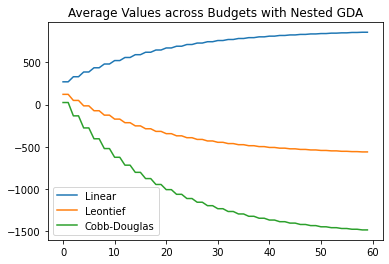

In [ ]:
avg_values_linear = np.average(values_hist_linear, axis = 1)
avg_values_leontief = np.average(values_hist_leontief, axis = 1)
avg_values_cd = np.average(values_hist_cd, axis = 1)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()


# Distance to Utility Maximization

## Algorithms

In [ ]:
def distance_between_cumul_utils(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices,
                                 num_iters_prices, num_iters_cumul, num_iters_single, num_samples_single):
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]

  ##################################### Based on VI ################################################
  cumul_utils_VI, excess_demands_hist = get_buyers_cumulative_util_deterministic_linear(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               num_iters_prices, num_iters_cumul)
  
  print(f"cumul_utils_VI: {cumul_utils_VI}")

  ##################################### Single buyer ##################################
  slope = 0
  intercept = 0

  cumul_utils_single = []
  # buyer 1
  opt_value_slope_1, opt_value_intercept_1 = single_buyer_val_iter(1, valuations, discount, slope, intercept, 
                                                                                            num_iters_single, num_samples_single, utility_type, 
                                                                                            value_coef, value_intercept)
  print("value for 1:", opt_value_slope_1 * initial_budgets[0] + opt_value_intercept_1)
  cumul_utils_single.append(opt_value_slope_1 * initial_budgets[0] + opt_value_intercept_1)
  # buyer 2
  opt_value_slope_2, opt_value_intercept_2 = single_buyer_val_iter(2, valuations, discount, slope, intercept, 
                                                                                            num_iters_single, num_samples_single, utility_type, 
                                                                                            value_coef, value_intercept)
  print("value for 2:", opt_value_slope_2 * initial_budgets[1] + opt_value_intercept_2)
  cumul_utils_single.append(opt_value_slope_2 * initial_budgets[1] + opt_value_intercept_2)

  # print
  print(f"cumul_utils_VI: {cumul_utils_VI}")
  print(f"cumul_utils_single: {cumul_utils_single}")
  print(f"distance: {np.linalg.norm(cumul_utils_VI - cumul_utils_single)}")
  print(f"excess_demands_hist: {excess_demands_hist}")
  return cumul_utils_VI, cumul_utils_single, np.linalg.norm(cumul_utils_VI - cumul_utils_single), excess_demands_hist


## Run Experiments

In [ ]:
num_goods = 2
num_buyers = 2
discount = 0.9



initial_budgets = np.repeat(10, num_buyers)


num_iters_cumul = 30 #30
num_iters_single = 30
num_iters_prices_linear = 200
num_iters_prices_leontief = 250
num_iters_prices_cd = 600

num_samples_single = 25

distance_collection = []
excess_demands_collection = []
for utility_type in ["linear"]:
    print(f"---------------------------------------{utility_type}--------------------------------------------")

    if utility_type == "linear":
      learn_rate_prices = 1
      value_coef = coef_hist_linear[-1]
      value_intercept = intercept_hist_linear[-1]
      num_iters_prices = num_iters_prices_linear
    elif utility_type == "leontief":
      learn_rate_prices = 1
      value_coef = coef_hist_leontief[-1]
      value_intercept = intercept_hist_leontief[-1]
      num_iters_prices = num_iters_prices_leontief
    elif utility_type == "cd":
      learn_rate_prices = 1
      value_coef = coef_hist_cd[-1]
      value_intercept = intercept_hist_cd[-1]
      num_iters_prices = num_iters_prices_cd

    print(f"value_coef: {value_coef}")
    print(f"value_intercept: {value_intercept}")

    cumul_utils_VI, cumul_utils_single, distance, excess_demands_hist = distance_between_cumul_utils(initial_budgets, valuations, utility_type, value_coef, 
                                                                                                     value_intercept, discount, learn_rate_prices, 
                                                                                                     num_iters_prices, num_iters_cumul, num_iters_single, num_samples_single)
    distance_collection.append(distance)
    excess_demands_collection.append(excess_demands_hist)

Streaming output truncated to the last 5000 lines.
 [9.99999993e-01 6.25837689e-12]]
prices: [9.07147497 9.86389957]
value: 787.3863996064484
excess demands: [-6.62409272e-09  1.00646096e-08]
buyer value: 309.19838314652327
buyer demands: [0.99999999 0.        ]
___sample 11___
------------------------------------------------------------------
budgets: [9.23060816 9.80054435]
demands: [[4.44107138e-08 9.99999950e-01]
 [9.99999968e-01 1.24167096e-08]]
prices: [9.80054445 9.23060794]
value: 788.0354657434314
excess demands: [ 1.23178503e-08 -3.72990588e-08]
buyer value: 309.1983829186064
buyer demands: [0.99999999 0.        ]
___sample 12___
------------------------------------------------------------------
budgets: [9.6653874 9.0634779]
demands: [[2.76331663e-08 9.99999974e-01]
 [9.99999979e-01 8.21456394e-09]]
prices: [9.06347796 9.66538729]
value: 786.4526110302004
excess demands: [ 6.24472629e-09 -1.73887570e-08]
buyer value: 309.19838306560854
buyer demands: [0.99999999 0.        ]


In [ ]:
print(cumul_utils_VI)
print(cumul_utils_single)
print(distance)
print(excess_demands_hist)

[320.38150999 431.50054731]
[array([320.38151367]), array([431.5005505])]
157.1460492644416
[8.652709167859545e-09, 5.107745084531069e-11, 8.438481712863078e-09, 1.7391119944964274e-08, 1.5305587091391737e-08, 1.876235503061219e-08, 1.0593898322448105e-08, 2.3579185122430753e-08, 3.0106213238849127e-08, 7.903647811869323e-09, 5.4417447047013345e-09, 1.1906243358655388e-08, 1.4802224507038779e-08, 1.627546161127637e-08, 9.298085386730282e-09, 1.7140960247047262e-08, 2.354300118061421e-08, 1.1547802821618983e-08, 1.441147448023253e-08, 8.331067745738686e-09, 2.1321708841835034e-08, 6.13121212727661e-09, 2.2159393173004477e-08, 7.812965525859235e-09, 2.2403838495168904e-08, 8.410440187676049e-08, 5.307616707083089e-08, 4.937518735341514e-08, 1.690973348651558e-08, 1.6577491934349532e-08]


In [ ]:
print(cumul_utils_VI)
cumul_util_single = np.array(cumul_utils_single).reshape(2)
print(cumul_util_single)
print(np.linalg.norm(cumul_utils_VI-cumul_util_single))

[320.38150999 431.50054731]
[320.38151367 431.5005505 ]
4.8696713857874255e-06


In [ ]:
print(distance_collection)
print(excess_demands_collection)

[157.1460492644416]
[[8.652709167859545e-09, 5.107745084531069e-11, 8.438481712863078e-09, 1.7391119944964274e-08, 1.5305587091391737e-08, 1.876235503061219e-08, 1.0593898322448105e-08, 2.3579185122430753e-08, 3.0106213238849127e-08, 7.903647811869323e-09, 5.4417447047013345e-09, 1.1906243358655388e-08, 1.4802224507038779e-08, 1.627546161127637e-08, 9.298085386730282e-09, 1.7140960247047262e-08, 2.354300118061421e-08, 1.1547802821618983e-08, 1.441147448023253e-08, 8.331067745738686e-09, 2.1321708841835034e-08, 6.13121212727661e-09, 2.2159393173004477e-08, 7.812965525859235e-09, 2.2403838495168904e-08, 8.410440187676049e-08, 5.307616707083089e-08, 4.937518735341514e-08, 1.690973348651558e-08, 1.6577491934349532e-08]]


In [ ]:
# cumul_utils_VI: [320.38150999 431.50054731]
# value for 1: [320.38151367]

## Make the table

In [ ]:
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Utility Type</b>','<b>Cumulative Utility based on VI</b>','<b>Maximized cumulative Utility</b>',
            '<b>Distance to Utility Maximization</b>','<b>Normalized Distance to Utility Maximization</b>', 
            '<b>Distance to Market Clearance (Average Excess Demands)</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['Linear (Nested GDA)', 'Linear (Max-oracle GD)', 'Leontief (Nested GDA)', 'Leontief (Max-oracle GD)', 'Cobb-Douglas (Nested GDA)', 'Cobb-Douglas (Max-oracle GD)'],
      ['[96.11864217, 872.44457586]', 
       '[58.83670238, 65.37844446]', 
       '[0.01241015, 0.01197241]', 
       '[0.0044322, 0.00609951]', 
       '[-759048.31311689, -844533.23523943]', 
       '[-763010.21531314 -847841.51430998]'],
      ['[84.79659719559233, 90.3457392997638]',
       '[96.96171820101995, 106.36975094410113]',
       '[0.009253314180356959, 0.008070244600082384]',
       '[0.012505356366874554, 0.00961266013048025]',
       '[-5410.446761817995, -5757.897160340484]', 
       '[-5482.763563167677, -5790.554467234857]'],
      [782.1807839960541, 55.98038976844064, 
       0.005019216377258324, 0.008804435107563718, 
       1127614.3407095883, 1132650.7224766547],
       [6.312670581380343,0.3889393929909976,
        0.408792752480498,0.5581970083770711,
        142.71734067443717, 142.0356741620785],
      [1.51360722680293,2.1650851972578646,
       2.1885091150520655,2.178489762142351, 
       2.1892506104891303, 2.1697254289647336]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor,rowEvenColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()


In [ ]:
util_vi = np.array([0.0044322, 0.00609951])
util_single = np.array( [0.012505356366874554, 0.00961266013048025])
print(np.linalg.norm(util_vi-util_single))
print(np.linalg.norm(util_vi-util_single) / np.linalg.norm(util_single))

0.008804435107563718
0.5581970083770711


## Make the Bar Plot

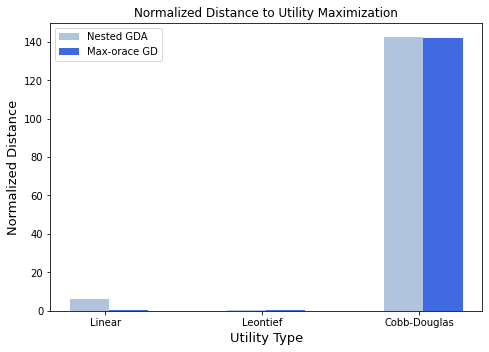

In [ ]:
data = [[6.312670581380343,0.408792752480498,142.71734067443717,],
[0.3889393929909976,0.5581970083770711,142.0356741620785]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Normalized Distance to Utility Maximization')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Normalized Distance', fontsize = 13)


plt.legend()
plt.show()

# Distance to Market Clearance

In [ ]:
excess_demands_linear_cvx = np.array([1.007923199446748, 0.011324849082771498, 0.011398197315511347, 0.011431693362778687, 0.011514927297107215, 0.01157807542950712, 0.011618352406576533, 0.011679292163442259, 0.011766210726685216, 0.30914232888117826, 2.2360644706166517, 2.2360648322261607, 2.236064444420647, 2.2360666169808168, 2.2360638937796753, 2.2360653979793996, 2.23606707800732, 2.236067013359693, 2.2360665546967753, 2.236061975729724, 2.2360672219546243, 2.23606755935085, 2.2360675492441127, 2.2360658551356996, 2.2360676760900065, 2.236067971670458, 2.2360669689675574, 2.2360469023876464, 2.2360624685748447])
excess_demands_leontief_cvx = np.array([0.9293471161358905, 2.188377777310114, 2.229028680982791, 2.2315775449161825, 2.2327239919492086, 2.2335727449365246, 2.2342056502220706, 2.234674796050045, 2.2350239910558742, 2.235279193011836, 2.2354710987066877, 2.235620769377735, 2.235726979420378, 2.2358152237564304, 2.2358752833842446, 2.235923677364442, 2.235959152434828, 2.2359960362954117, 2.236017831284798, 2.236032348195055, 2.2360419838953502, 2.2360495106489986, 2.2360543575158216, 2.2360577367925876, 2.2360600743323733, 2.2360620043457797, 2.2360618811860014, 2.236063053510682, 2.236063847491746])
excess_demands_cd_cvx = np.array([0.878369719707621, 2.236067847485999, 2.2360677299612814, 2.236067670026975, 2.236067646686249, 2.236067924533268, 2.2360676432399735, 2.2360679257193556, 2.2360676419982752, 2.2360679249417434, 2.2360676417874736, 2.236067924783226, 2.2360676417662018, 2.2360679246573407, 2.2360676418047785, 2.236067924852683, 2.236067642098393, 2.2360679249652864, 2.2360676417504823, 2.236067925625168, 2.236067641510322, 2.236067925285582, 2.2360676418598504, 2.2360679253504068, 2.236067923609602, 2.2360676440170857, 2.236067924884247, 2.23606764237371, 2.2360679269021975])

excess_demands_linear_heuristic = np.array([0.17758096980109522, 2.2360679775187116, 2.236054700354538, 2.2360679457155266, 2.236067950605495, 2.2360679537217085, 2.236067955980454, 2.2360679577458273, 2.236067959219619, 2.2360679604972664, 2.236067961645776, 2.2360679627171383, 2.236067963738487, 2.2360679647352497, 2.2360679657244362, 2.2360679667155727, 2.2360679677179447, 2.2360679687286, 2.2360679697424453, 2.236067969883648, 2.2360679699314385, 2.236067969960027, 2.236067969963552, 2.236067969943169, 2.236067969893672, 2.2360679698093997, 2.2360679696861667, 2.2360679695112857, 2.236067969269816])
excess_demands_leontief_heuristic = np.array([0.566528032626108, 2.2360679775068184, 2.2358397023466123, 2.236067976285023, 2.236067976461301, 2.236067977015341, 2.2360679764486684, 2.2360679765398452, 2.23606797641845, 2.2360679766418077, 2.2360679764491875, 2.2360679764780214, 2.236067976166385, 2.23606797643746, 2.236067976770492, 2.236067976784724, 2.2360679766305465, 2.236067976559505, 2.236067976658762, 2.2360679766268046, 2.236067977061843, 2.2360679763690956, 2.2360679763690117, 2.236067976502387, 2.236067976476328, 2.236067976011311, 2.236067976486751, 2.236067976671927, 2.236067976327661])
excess_demands_cd_heuristic = np.array([0.3123618740016494, 2.236067977506149, 2.2358401939400605, 2.2360679767090654, 2.2360679766883274, 2.2360679767731315, 2.2360679769866607, 2.2360679761812126, 2.236067976420635, 2.2360679770746184, 2.2360679766684926, 2.236067976645758, 2.2360679769932954, 2.236067977008064, 2.236067976619816, 2.2360679770529246, 2.2360679770358294, 2.2360679767441054, 2.2360679768428526, 2.236067976486209, 2.236067976667855, 2.236067976646691, 2.2360679770109146, 2.236067976624189, 2.236067976637902, 2.2360679763400824, 2.2360679764441302, 2.236067976582384, 2.236067976644269])


EDnorm_linear_cvx = np.mean(excess_demands_linear_cvx)
EDnorm_leontief_cvx = np.mean(excess_demands_leontief_cvx)
EDnorm_cd_cvx = np.mean(excess_demands_cd_cvx)

print(EDnorm_linear_cvx)
print(EDnorm_leontief_cvx)
print(EDnorm_cd_cvx)

EDnorm_linear_heuristic = np.mean(excess_demands_linear_heuristic)
EDnorm_leontief_heuristic = np.mean(excess_demands_leontief_heuristic)
EDnorm_cd_heuristic = np.mean(excess_demands_cd_heuristic)

print("linear_heu", EDnorm_linear_heuristic)
print("leontief_heu", EDnorm_leontief_heuristic)
print("cd_heu", EDnorm_cd_heuristic)


1.51360722680293
2.1885091150520655
2.1892506104891303
linear_heu 2.1650851972578646
leontief_heu 2.178489762142351
cd_heu 2.1697254289647336


### Make the Bar Plot

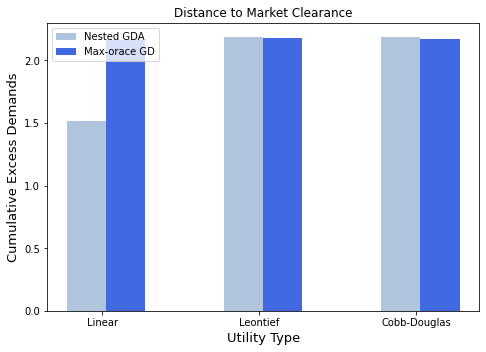

In [ ]:
data = [[1.51360722680293, 2.1885091150520655, 2.1892506104891303],
      [2.1650851972578646,2.178489762142351, 2.1697254289647336]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Distance to Market Clearance')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Cumulative Excess Demands', fontsize = 13)


plt.legend()
plt.show()